In [40]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import statsmodels.api as sm
from cabm import post_processing as ppr

In [41]:
# Figure setup
# Set the font to Courier
mpl.rcParams['font.family'] = 'Courier'

# Set the line weight to thin
mpl.rcParams['lines.linewidth'] = 0.75

# Set the color scheme to black and white
mpl.rcParams['text.color'] = 'black'
mpl.rcParams['axes.labelcolor'] = 'black'
mpl.rcParams['xtick.color'] = 'black'
mpl.rcParams['ytick.color'] = 'black'
mpl.rcParams['axes.edgecolor'] = 'black'

In [42]:
agent_df = pd.read_pickle('SIM_OUTPUTS/agent_output_A_and_B_All.pkl')

In [43]:
agent_df = ppr.add_date_column(agent_df)

In [44]:
aggregate_df = ppr.calculate_total_purchases(agent_df, ['price_A','tv_A','web_A', 'price_B', 'tv_B', 'web_B'], ['Total_Purchases_A', 'Total_Purchases_B'])

In [45]:
aggregate_df = ppr.add_total_sales_columns(aggregate_df, ['Total_Purchases_A', 'Total_Purchases_B'],  ['price_A','price_B'])

In [46]:
aggregate_df = ppr.ensure_float_columns(aggregate_df, exclude_columns=['Date','Step'])

### Functions below need to be generalized and added to post_processing.py

In [47]:
def calculate_average_adstock(agent_df):
    '''
    Computes average adstock per brand per step from agent level output
    '''
    # Initialize empty lists to store the results
    average_adstock_A = []
    average_adstock_B = []
    dates = []
    steps = []

    # Iterate over the 'Ad_Stock' column
    for index, row in agent_df.iterrows():
        # Append the adstock for each brand to the respective list
        average_adstock_A.append(row['Adstock']['A'])
        average_adstock_B.append(row['Adstock']['B'])
        dates.append(row['Date'])
        steps.append(index[0])  # Assuming 'Step' is the first level of the index

    # Create a new DataFrame with the average adstock for each brand
    average_adstock_df = pd.DataFrame({
        'Average_Adstock_A': average_adstock_A,
        'Average_Adstock_B': average_adstock_B,
        'Date': dates,
    })

    # Group by 'Date' and 'Step' and calculate the average adstock
    average_adstock_df = average_adstock_df.groupby(['Date']).mean().reset_index()

    return average_adstock_df

In [48]:
average_adstock_df = calculate_average_adstock(agent_df)

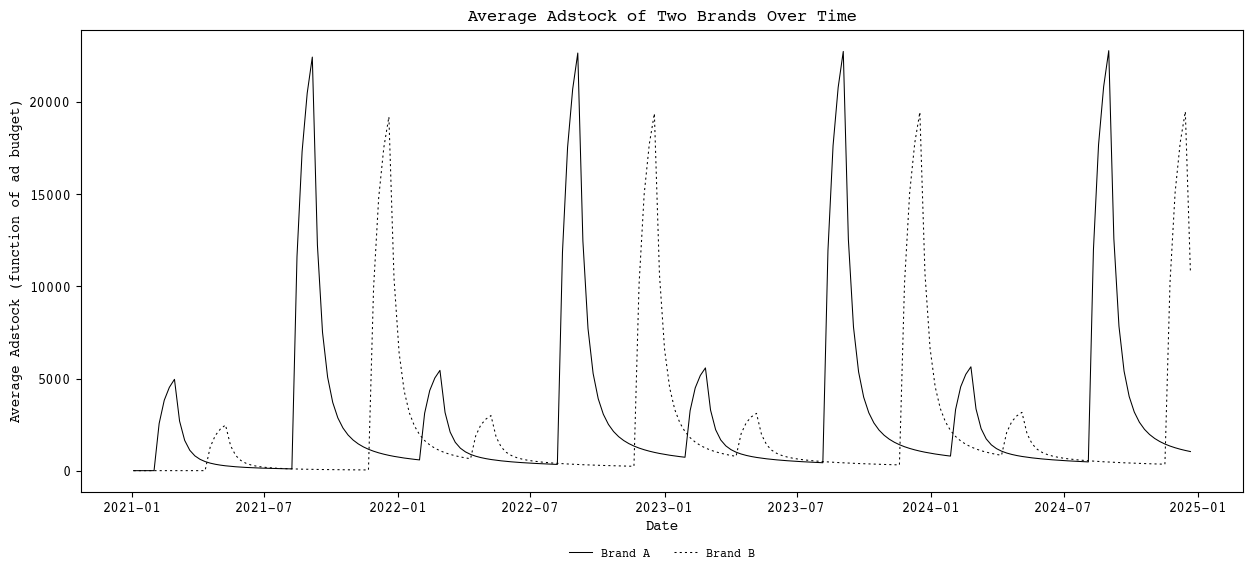

In [49]:
# Create the plot
plt.figure(figsize=(15,6))

plt.plot(average_adstock_df['Date'], average_adstock_df['Average_Adstock_A'], label='Brand A', color='black')
plt.plot(average_adstock_df['Date'], average_adstock_df['Average_Adstock_B'], label='Brand B', color='black', linestyle='--', dashes=[2,3])

plt.title('Average Adstock of Two Brands Over Time')
plt.xlabel('Date')
plt.ylabel('Average Adstock (function of ad budget)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.10), ncol=2, fontsize='small', frameon=False)

plt.savefig("adstock_no_ad.png", dpi=200)
plt.show()

In [50]:
def plot_agent_adstock(agent_df, agent_id):
    '''
    Plots adstock per brand per step for a specific agent from agent level output
    '''
    # Filter the DataFrame for the specified agent
    agent_df_filtered = agent_df.xs(agent_id, level='AgentID')

    # Initialize empty lists to store the results
    adstock_A = []
    adstock_B = []
    dates = []

    # Iterate over the 'Ad_Stock' column
    for index, row in agent_df_filtered.iterrows():
        # Append the adstock for each brand to the respective list
        adstock_A.append(row['Adstock']['A'])
        adstock_B.append(row['Adstock']['B'])
        dates.append(row['Date'])

    # Create the plot
    plt.figure(figsize=(15,6))

    plt.plot(dates, adstock_A, label='Brand A', color='black')
    plt.plot(dates, adstock_B, label='Brand B', color='black', linestyle='--', dashes=[2,3])

    plt.title(f'Adstock of Two Brands Over Time for Agent {agent_id}')
    plt.xlabel('Date')
    plt.ylabel('Adstock')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.10), ncol=2, fontsize='small', frameon=False)

    plt.show()

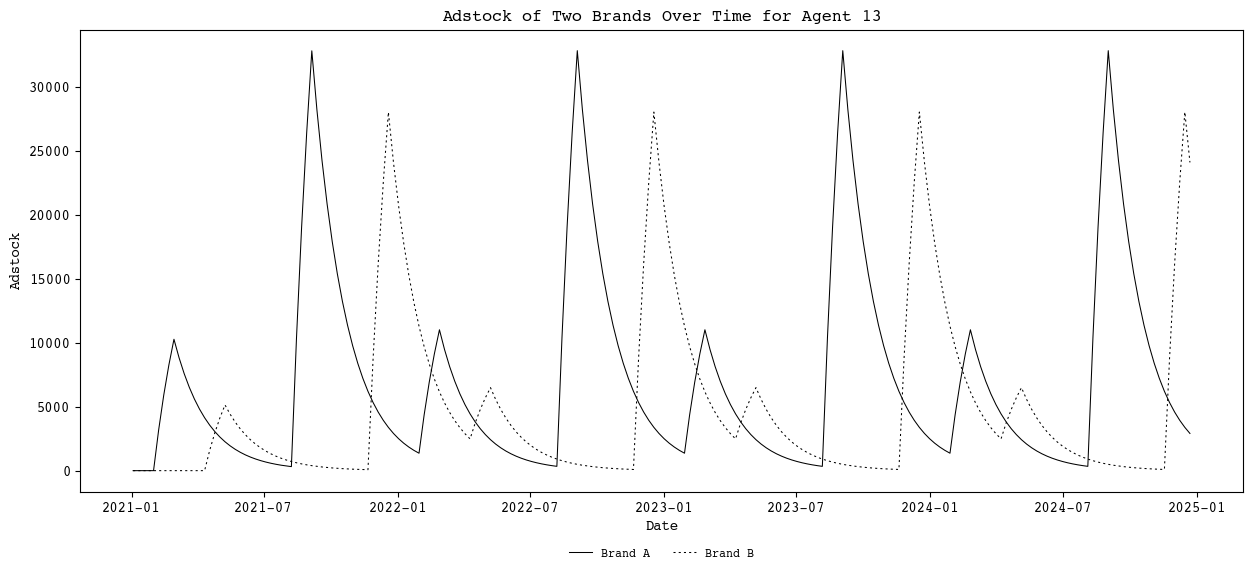

In [51]:
plot_agent_adstock(agent_df, 13)

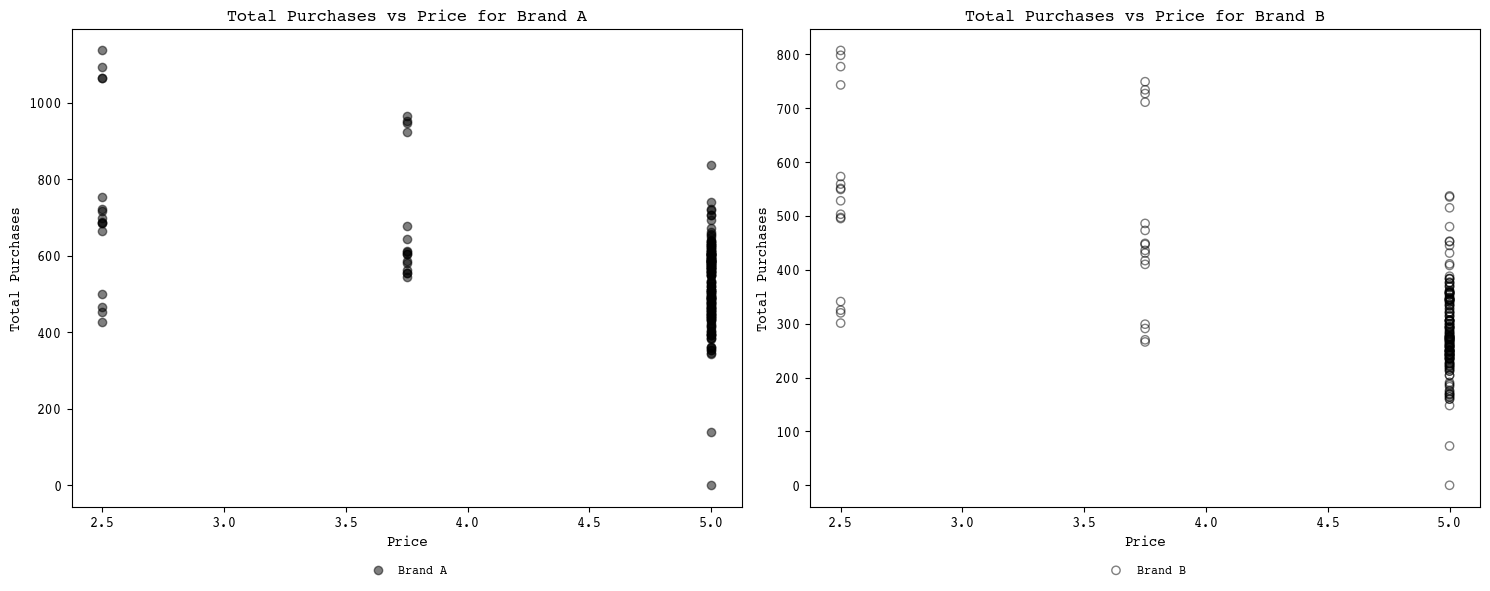

In [52]:
fig, axs = plt.subplots(1, 2, figsize=(15,6))

# Scatter plot for Brand A with filled black circles and transparency
axs[0].scatter(aggregate_df['price_A'], aggregate_df['Total_Purchases_A'], 
            label='Brand A', color='black', alpha=0.5)
axs[0].set_title('Total Purchases vs Price for Brand A')
axs[0].set_xlabel('Price')
axs[0].set_ylabel('Total Purchases')
axs[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.10), ncol=2, fontsize='small', frameon=False)

# Scatter plot for Brand B with unfilled black circles and transparency
axs[1].scatter(aggregate_df['price_B'], aggregate_df['Total_Purchases_B'], 
            label='Brand B', facecolor='none', edgecolor='black', alpha=0.5)
axs[1].set_title('Total Purchases vs Price for Brand B')
axs[1].set_xlabel('Price')
axs[1].set_ylabel('Total Purchases')
axs[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.10), ncol=2, fontsize='small', frameon=False)

plt.tight_layout()
plt.show()


### Estimate elastcity using log-log regression

In [53]:
# Take the natural log of 'Total_Purchases_A' and 'Price_A' for Brand A
aggregate_df['ln_Total_Purchases_A'] = np.log(aggregate_df['Total_Purchases_A'])
aggregate_df['ln_Price_A'] = np.log(aggregate_df['price_A'])

# Define the dependent variable and the independent variables
Y = aggregate_df['ln_Total_Purchases_A']
X = aggregate_df['ln_Price_A']
X = sm.add_constant(X)  # Add a constant to the independent variables

# Fit the model
model = sm.OLS(Y, X)
results = model.fit()

# The coefficient of 'ln_Price_A' is the price elasticity of demand for Brand A
elasticity_A = results.params['ln_Price_A']

# Repeat the process for Brand B
aggregate_df['ln_Total_Purchases_B'] = np.log(aggregate_df['Total_Purchases_B'])
aggregate_df['ln_Price_B'] = np.log(aggregate_df['price_B'])

Y = aggregate_df['ln_Total_Purchases_B']
X = aggregate_df['ln_Price_B']
X = sm.add_constant(X)

model = sm.OLS(Y, X)
results = model.fit()

elasticity_B = results.params['ln_Price_B']

/Users/MikeFitzgerald/venvs/py311_mesa/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/MikeFitzgerald/venvs/py311_mesa/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [57]:
elasticity_A

-inf

In [58]:
agent_df.columns

Index(['Household_Size', 'Consumption_Rate', 'Brand_Preference',
       'Brand_Choice', 'Loyalty_Rate', 'Purchase_Probabilities', 'Enable_Ads',
       'Ad_Decay_Factor', 'Ad_Channel_Preference', 'Adstock', 'Pantry_Min',
       'Pantry_Max', 'Pantry_Stock', 'Purchased_This_Step', 'Current_Price',
       'Last_Product_Price', 'Purchase_Behavior', 'Step_Min', 'Step_Max',
       'price_A', 'tv_A', 'web_A', 'price_B', 'tv_B', 'web_B', 'Date'],
      dtype='object')

In [59]:
def get_agent_purchases_and_price(agent_df, agent_id):
    '''
    Retrieves purchases and price per brand per step for a specific agent from agent level output
    '''
    # Filter the DataFrame for the specified agent
    agent_df_filtered = agent_df.xs(agent_id, level='AgentID')
    
    # Initialize empty lists to store the results
    purchases_A = []
    purchases_B = []
    price_A = []
    price_B = []
    dates = []

    # Iterate over the 'Purchased_This_Step' and 'Current_Price' columns
    for index, row in agent_df_filtered.iterrows():
        # Append the purchases and price for each brand to the respective list
        purchases_A.append(row['Purchased_This_Step']['A'])
        purchases_B.append(row['Purchased_This_Step']['B'])
        price_A.append(row['price_A'])
        price_B.append(row['price_B'])
        dates.append(row['Date'])

    # Create a new DataFrame with the purchases and price for each brand
    agent_purchases_and_price_df = pd.DataFrame({
        'Date': dates,
        'Purchases_A': purchases_A,
        'Price_A': price_A,
        'Purchases_B': purchases_B,
        'Price_B': price_B,
    })

    return agent_purchases_and_price_df

In [60]:
agent_purchases_and_price_df = get_agent_purchases_and_price(agent_df, 431)

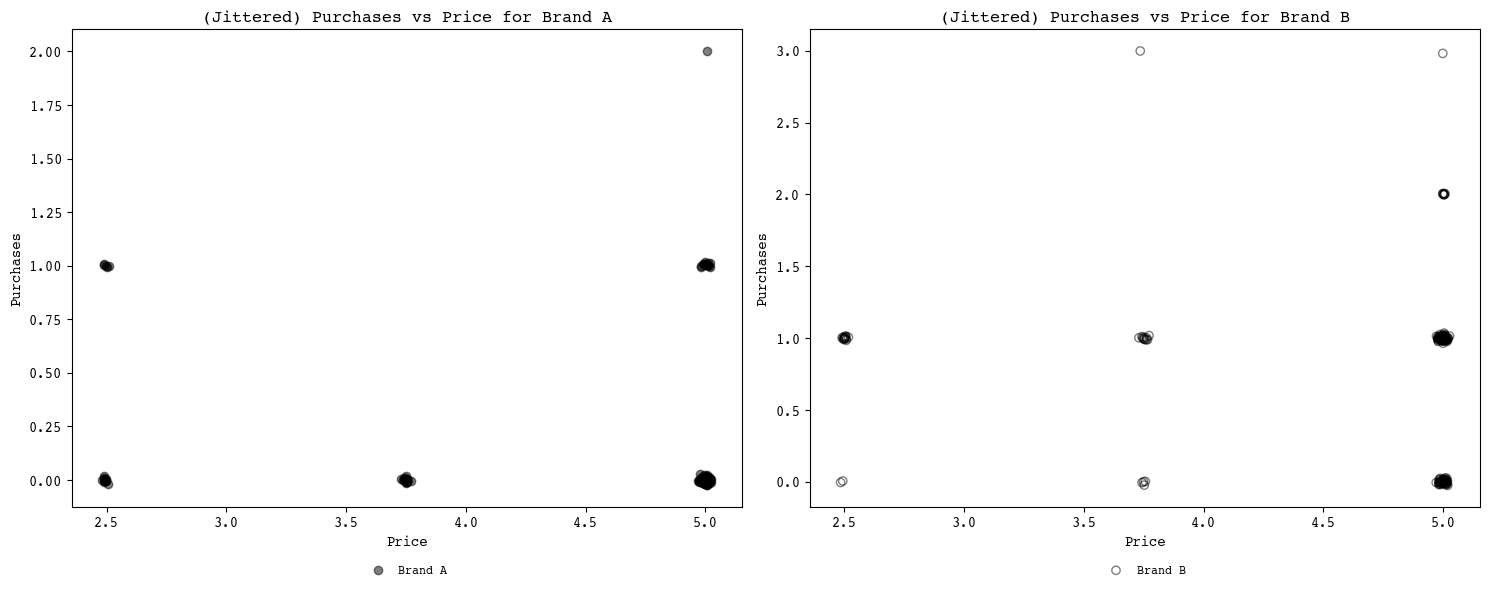

In [61]:
fig, axs = plt.subplots(1, 2, figsize=(15,6))

# Scatter plot for Brand A with filled black circles and transparency
axs[0].scatter(agent_purchases_and_price_df['Price_A'] + np.random.normal(0, 0.01, size=len(agent_purchases_and_price_df['Price_A'])), 
               agent_purchases_and_price_df['Purchases_A'] + np.random.normal(0, 0.01, size=len(agent_purchases_and_price_df['Purchases_A'])), 
               label='Brand A', color='black', alpha=0.5)
axs[0].set_title('(Jittered) Purchases vs Price for Brand A')
axs[0].set_xlabel('Price')
axs[0].set_ylabel('Purchases')
axs[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.10), ncol=2, fontsize='small', frameon=False)

# Scatter plot for Brand B with unfilled black circles and transparency
axs[1].scatter(agent_purchases_and_price_df['Price_B'] + np.random.normal(0, 0.01, size=len(agent_purchases_and_price_df['Price_B'])), 
               agent_purchases_and_price_df['Purchases_B'] + np.random.normal(0, 0.01, size=len(agent_purchases_and_price_df['Purchases_B'])), 
               label='Brand B', facecolor='none', edgecolor='black', alpha=0.5)
axs[1].set_title('(Jittered) Purchases vs Price for Brand B')
axs[1].set_xlabel('Price')
axs[1].set_ylabel('Purchases')
axs[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.10), ncol=2, fontsize='small', frameon=False)

plt.tight_layout()
plt.show()

In [34]:
# Define the dependent variable and the independent variables
Y = agent_purchases_and_price_df['Purchases_A']
X = agent_purchases_and_price_df['Price_A']
X = sm.add_constant(X)  # Add a constant to the independent variables

# Fit the model
poisson_model = sm.GLM(Y, X, family=sm.families.Poisson())
poisson_results = poisson_model.fit()

# The coefficient of 'Price_A' is the price elasticity of demand for Brand A
elasticity_A = poisson_results.params['Price_A']

# Repeat the process for Brand B
Y = agent_purchases_and_price_df['Purchases_B']
X = agent_purchases_and_price_df['Price_B']
X = sm.add_constant(X)

poisson_model = sm.GLM(Y, X, family=sm.families.Poisson())
poisson_results = poisson_model.fit()

elasticity_B = poisson_results.params['Price_B']

In [35]:
elasticity_A

-0.07634220442001141

In [36]:
elasticity_B

-0.4010667139052232

In [37]:
# Define the dependent variable and the independent variables
Y = agent_purchases_and_price_df['Purchases_A']
X = agent_purchases_and_price_df['Price_A']
X = sm.add_constant(X)  # Add a constant to the independent variables

# Fit the Zero-Inflated Poisson model
zip_model_A = sm.ZeroInflatedPoisson(Y, X).fit()

# The coefficient of 'Price_A' is the price elasticity of demand for Brand A
elasticity_A = zip_model_A.params['Price_A']

# Repeat the process for Brand B
Y = agent_purchases_and_price_df['Purchases_B']
X = agent_purchases_and_price_df['Price_B']
X = sm.add_constant(X)

zip_model_B = sm.ZeroInflatedPoisson(Y, X).fit()

elasticity_B = zip_model_B.params['Price_B']

Optimization terminated successfully.
         Current function value: 1.080229
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.396424
         Iterations: 7
         Function evaluations: 14
         Gradient evaluations: 14


In [38]:
elasticity_A

-0.07634209509595002

In [39]:

elasticity_B

-0.0669807461107645